#**Laboratorio de MongoDB: Transacciones y Concurrencia**

**Creado por:** Andrea Valentina Campaña Intriago.

Bienvenido a este laboratorio práctico de MongoDB. Aprenderemos paso a paso los conceptos fundamentales sobre  operaciones de transacciones y control de concurrencia, junto a casos de usos prácticos partiendo de una base de datos NoSQL, la cual se creará poco a poco mediante los *scripts* del presente documento.


**Objetivo general**

Comprender y aplicar el uso de transacciones y control de concurrencia en MongoDB mediante ejemplos prácticos en Python, garantizando la integridad y consistencia de los datos en operaciones críticas como transferencias.

**Objetivos específicos:**

*   Conectarse a MongoDB Atlas desde Python utilizando PyMongo.
*   Comprender el concepto de sesiones y su uso en transacciones.
*   Implementar transacciones para realizar transferencias seguras entre documentos.
*   Analizar cómo MongoDB maneja la concurrencia cuando varios procesos acceden a los datos.
*   Manejar errores y conflictos en transacciones
*   Aplicar el patrón de reintento (retry logic) en caso de fallos de concurrencia.
*   Evaluar cuándo es necesario utilizar transacciones y cuándo no.



---



## **1. Fundamentos de transacciones y concurrencia**

### **1.1. Transacciones**

Las **transacciones** en MongoDB permiten ejecutar múltiples operaciones **(insertar, actualizar o eliminar)** como si fueran una sola **unidad**. Si algo falla, se revierte todo el proceso, garantizando coherencia en los datos. Esto se logra aplicando propiedades ACID, controlando conflictos, definiendo niveles de aislamiento y lo implementa mediante sesiones, donde el sistema controla cuándo iniciar, confirmar **(commit)** o deshacer **(rollback)** una transacción.

### **1.2. Propiedades ACID**

| Propiedad            | Significado                                  | En MongoDB                |
| -------------------- | -------------------------------------------- | ------------------------- |
| **A – Atomicidad**   | Todas las operaciones se completan o ninguna | commit / abort            |
| **C – Consistencia** | El estado final cumple reglas del negocio    | validaciones, constraints |
| **I – Aislamiento**  | Una transacción no ve datos de otra          | snapshot isolation        |
| **D – Durabilidad**  | Lo confirmado no se pierde                   | journal + replicación     |


### **1.3. Concurrencia**

La **concurrencia** se refiere a la capacidad que tiene la base de datos para permitir que múltiples usuarios o procesos accedan y modifiquen los datos al mismo tiempo. MongoDB debe asegurarse de que estos accesos simultáneos no generen inconsistencias. Es decir, las transacciones ayudan a manejar la concurrencia asegurando que, si dos operaciones se ejecutan al mismo tiempo, los datos se mantengan correctos.

MongoDB usa:
*   Bloqueos internos (*locks*) para manejar acceso concurrente.
*   Control optimista de concurrencia mediante el patrón *retry logic*.
*   Sesiones para ejecutar transacciones.

### **1.4. Ejemplo gráfico de transaccionabilidad y concurrencia**

Por ejemplo, en el siguiente gráfico, primero se inicia una sesión y luego la transacción, dentro de la cual se realizan varias operaciones. Al final, el sistema verifica si hubo errores: si algo falla, se ejecuta un rollback y se revierten los cambios; si todo está correcto, se confirma con un commit. Este mecanismo garantiza que los datos se mantengan consistentes y seguros incluso cuando varios usuarios operan al mismo tiempo.

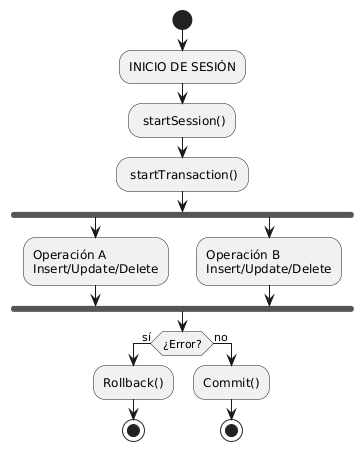

### **1.5. Límites y restricciones en las transacciones**



*   **No funcionan en todos los entornos:** Las transacciones solo están disponibles cuando MongoDB se ejecuta en *Replica Sets o Clusters Sharded,* es decir, si usas una instancia simple (**standalone**), no podrás usar transacciones.
*  **Tiempo y tamaño limitados:** Transacciones deben ser cortas y no superar ~100 MB.
*   **No todo se puede hacer dentro de una transacción:** Algunas acciones administrativas, como crear o modificar índices o ejecutar comandos del sistema, no están permitidas dentro de una transacción.
*   **Pueden afectar al rendimiento si se usan mal:** Si una transacción es muy grande o compleja, puede ralentizar la base de datos, ya que MongoDB debe asegurar la consistencia y el aislamiento de los datos.

Las transacciones deben usarse solo cuando son realmente necesarias, especialmente en operaciones críticas como pagos, reservas o transferencias.

### **1.6. Compatibilidad con versiones**


*   Las transacciones que cumplen con las propiedades ACID están disponibles a partir de la versión 4.0 de MongoDB.
*   Si tu base de datos está distribuida en varios nodos (*cluster sharded*), las transacciones solo funcionan desde MongoDB 4.2 en adelante.
*   La versión del driver (por ejemplo, PyMongo) debe ser compatible con la versión del servidor MongoDB.

Si uno está desactualizado, las transacciones pueden fallar o no funcionar correctamente.

### **1.7. ¿Por qué es importante esto en MongoDB?**



MongoDB, al ser NoSQL, inicialmente es más flexible pero menos estricto en operaciones críticas. Las transacciones se volvieron necesarias en escenarios como:
*  **E-commerce:** si un cliente paga, debe reducir stock y registrar orden al mismo tiempo.
*  **Reservas:** un asiento, cita o habitación debe ser asignado solo a una persona.
*   **Banca:** transferir implica restar en una cuenta y sumar en otra sin fallos.

Este concepto mejora la confiabilidad, evita datos corruptos y permite competir con bases tradicionales (SQL) sin perder velocidad ni escalabilidad. Aquí una tabla comparatida de MongoDb con SQL:

| Característica          | SQL      | MongoDB            |
| ----------------------- | -------- | ------------------ |
| Transacciones complejas | Nativas  | Desde versión 4.0  |
| Multi-documento         | Siempre  | Sí, con sesiones   |
| Escalabilidad           | Vertical | Horizontal         |
| Ideal para              | Bancos   | Apps de alta carga |


En aplicaciones reales (billeteras digitales, carritos de compra, reservas, inventarios) es necesario asegurar que los datos sean coherentes, aún cuando varias personas operan al mismo tiempo.



---



## **2. Operaciones Transaccionales**

### **2.1. Iniciar y finalizar transacciones**

Como se vió, las transacciones se ejecutan dentro de una sesión.

*   Se inicia con `startSession()` y `startTransaction()`.
*   Y se finalizan con **commit()** (guardar los cambios) o `abort()` y `rollback()` (para revertir los cambios).

### **2.2. Manejo de errores en transacciones**

Si falla la red con *conflict* (**conflicto**) o *timeout* (**fuera de tiempo**), se debe reintentar la transacción, usando `try/except`.

## **3. Control de Concurrencia**

### **3.1. Niveles de aislamiento**

Definen qué tan protegida está una transacción frente a cambios ajenos.

Evitan problemas como:

*   **Lecturas sucias:** Ver datos que aún no fueron confirmados.
*   **Lecturas repetidas:** El dato cambia dentro de la misma transacción.

MongoDB maneja aislamiento garantizando que los cambios solo se vean después del commit.

### **3.2. *Locking* y concurrencia**

MongoDB usa bloqueos internos inteligentes: No bloquea toda la base, solo lo necesario (colección o documento) y permite que muchos usuarios trabajen al mismo tiempo sin pisarse los datos.

*   Es decir, dos usuarios editan el mismo documento y MongoDB asegura **orden y consistencia** de los cambios.



### **3.3. *Optimistic Concurrency Control***

Se usa cuando los conflictos son poco frecuentes. Trabaja asumiendo que "todo saldrá bien" sin bloquear antes.
*   Es decir, si dos personas cambian el mismo dato, MongoDB detecta el conflicto y se rehace o reintenta la operación.



### **3.4. Patrones de *retry***

Se aplican cuando una transacción falla por concurrencia y el sistema intenta nuevamente hasta que pueda completarse.
*   Ejemplo, si dos usuarios reservan el mismo asiento, el primero lo logra, pero el segundo reintenta hasta encontrar otro disponible.




---



## **4. Casos de uso típicos en empresas y aplicaciones**

### **4.1. Transferencias bancarias**

Una transacción asegura que el dinero se descuente de una cuenta y se sume en la otra, sin errores.
Si algo falla, se cancela todo y ningún dinero desaparece.

### **4.2. Sistemas de reservas (vuelos, hoteles, etc.)**

Las transacciones evitan que dos personas reserven el mismo asiento o habitación al mismo tiempo.
Solo la primera transacción en completarse gana.


### **4.3. Carritos de compra**

Cuando el usuario confirma la compra:

*   Se verifica disponibilidad.
*   Se descuentan productos del inventario.
*   Se registra la orden.
*   Todo ocurre junto, o no ocurre nada si hay un error.

### **4.4. Sistemas de inventario**

Cada venta o devolución debe actualizar las cantidades correctamente.
Las transacciones evitan resultados imposibles como un inventario negativo.



### **4.5. Procesamiento de órdenes**

Combina varias acciones: generar factura, reducir stock, registrar pago y envío.
Una transacción asegura que todas las operaciones se cumplan en conjunto.

### **4.6. Tabla de casos de uso**

| Aplicación               | Ejemplo                | Por qué requiere transacción           |
| ------------------------ | ---------------------- | -------------------------------------- |
| Transferencias bancarias | Banco Pichincha        | No puede perder dinero                 |
| Reservas                 | Booking, Airbnb        | Evitar doble reserva                   |
| Carrito de compras       | Amazon, Shein          | Confirmar stock y pago al mismo tiempo |
| Inventario               | Bodegas, supermercados | No vender sin stock                    |
| Ordenes y facturación    | Rappi, Uber Eats       | Proceso debe ser seguro                |


 ## **5. Ventajas y desventajas**


### **5.1. Ventajas de usar transacciones en MongoDB**


*  **Mantienen los datos correctos y consistentes:** Evitan que la base de datos quede en un estado incorrecto cuando algo falla a mitad de una operación.
*   **Permiten trabajar con varios documentos a la vez:** Varias operaciones relacionadas se ejecutan juntas, como si fueran una sola acción.
*   **Hacen más seguros los sistemas importantes:** Son ideales para sistemas sensibles como pagos, reservas o inventarios, donde los errores no son aceptables.
*   **Funcionan en entornos distribuidos:** Se pueden utilizar incluso cuando la base de datos está repartida en varios servidores (**clusters**).



### **5.2. Desventajas de usar transacciones en MongoDB**


* **Usan más recursos del sistema:** Al controlar errores y coherencia, las transacciones consumen más memoria y procesamiento.
*  **Son más lentas que operaciones normales:** Una operación simple sin transacción suele ejecutarse más rápido.
*   **No siempre son necesarias:** Para tareas sencillas (como leer o insertar un solo documento), usar transacciones no aporta beneficios.
*   **Requieren versiones modernas:** Solo funcionan correctamente en MongoDB 4.0 o superior, junto con drivers compatibles.




---



# **Instalación y configuración de MongoDb Atlas**

Para interactuar con MongoDB desde Python, utilizamos el driver oficial llamado `pymongo`. Este driver actúa como un puente que permite a nuestro código Python enviar comandos a la base de datos MongoDB.

Si estás ejecutando este notebook en un entorno local y no tienes `pymongo` instalado, la siguiente celda lo instalará por ti.

In [1]:
%pip install "pymongo[srv]"

Note: you may need to restart the kernel to use updated packages.


###**Conexión a MongoDB Atlas desde Google Colab**

En esta sección configuramos la conexión entre nuestro notebook y MongoDB Atlas.
Para poder trabajar con transacciones, colecciones y operaciones de base de datos, necesitamos crear un cliente de conexión usando el driver PyMongo.

El siguiente bloque de código importa las librerías necesarias para:


*   Crear el cliente (`MongoClient`).
*   Especificar la versión del servidor con `ServerApi`.
*   Leer de forma segura nuestra contraseña (opcional en Colab).
*   Codificar caracteres especiales en la cadena de conexión.

In [2]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from getpass import getpass
from urllib.parse import quote_plus

### **Cadena de conexión y contraseña**

Para poder conectar con tu base de datos en MongoDB (previamente creada en un Clúster) debes conseguir tu URI de conexión.
En Atlas, ve a `Connect > Drivers > Python` y copia tu cadena de conexión, similar a la siguiente:

`uri = "mongodb+srv://<db_username>:<db_password>@cluster0.3txr9z5.mongodb.net/?appName=Cluster0"`


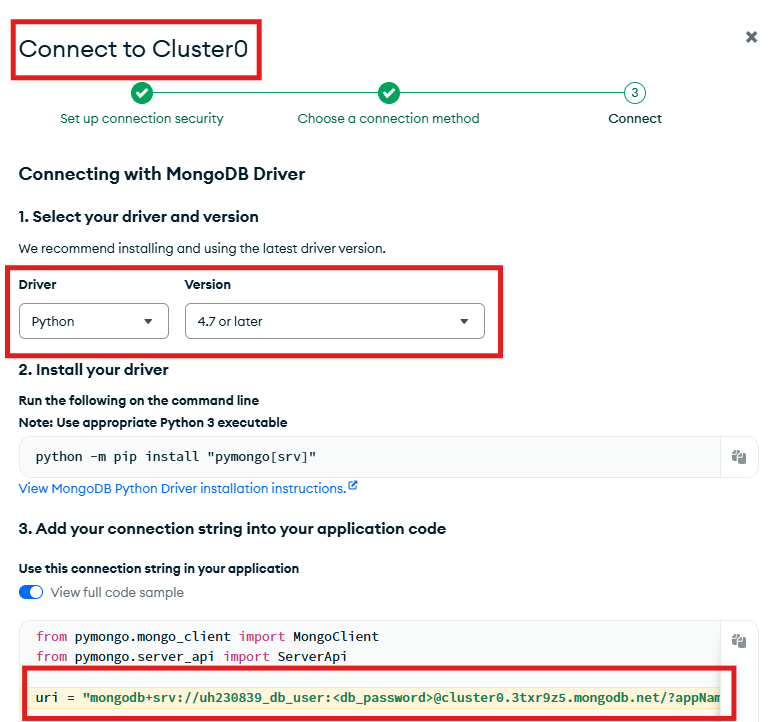

Después, deberás tener copiada tu contraseña de tu base de datos. La contraseña la encontrarás en la pestaña `SECURITY --> Database & Network Access` y ya dentro acceder a `NETWORK ACCESS > Database Users > Tu usuario > Edit`. **¡No te olvides copiarla!**

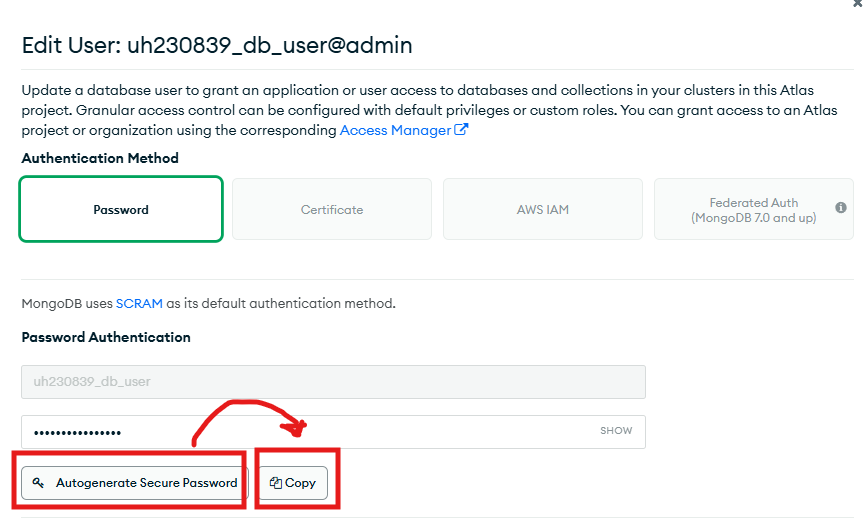

### **IMPORTANTE: Configurar dirección IP**

Es importante agregar tu direccion IP a la lista de IP's permitidas en tu base de datos de MongoDB Atlas. En caso de que estes trabajando desde Google Colab, deberás agregar la red `0.0.0.0/0` ya que Google Colab no tiene una IP fija.
Ingresar a `SECURITY --> Database & Network Access` y después a `NETWORK ACCESS > IP Access List > ADD IP ADDRESS`

* **NOTA:** Esta práctica es ÚNICAMENTE para fines educativos y no se recomienda en un entorno de producción.




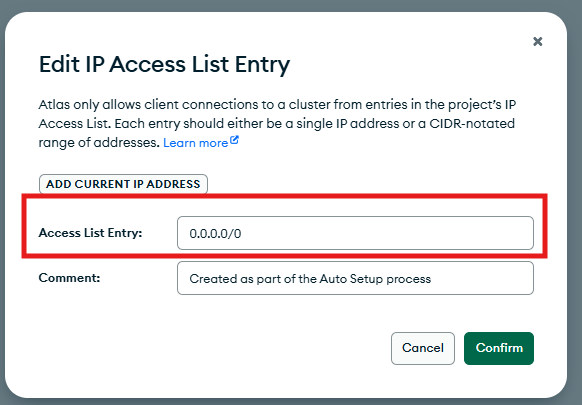



---



### **Conexión a MongoDB**

Aquí deberás ingresar tu URI de conexión y contraseña cuando te sea solicitado.


In [5]:
from connect_atlas import conectar_atlas

client = conectar_atlas()

Por favor, ingresa tu cadena de conexión de MongoDB Atlas:
Ahora, ingresa tu contraseña de MongoDB Atlas:

¡Ping exitoso! Conexión establecida con MongoDB Atlas.


Si te imprime el mensaje "**¡Ping exitoso! Te has conectado correctamente a MongoDB Atlas**", está todo en orden.

### **Operación básica para confirmar conexión**

Si la base de datos o colección `mycollection` no existen, MongoDB las creará en tu base de datos la primera vez que insertes un documento.

In [6]:
# Seleccionar una base de datos y una colección
db = client['mongoycolab']
collection = db['mycollection']

print(f"Conectado a la base de datos: {db.name}")
print(f"Usando la colección: {collection.name}")

Conectado a la base de datos: mongoycolab
Usando la colección: mycollection


### **Insertar documentos a la colección**

Insercción de cinco registros a la colección `mycollection`.

In [ ]:
from documents_to_colection import insertar_documentos

# Suponiendo que ya tienes client y db creados:
collection = db["personas"]
insertar_documentos(collection) # llamar a la función para insertar_documentos

Documentos insertados con IDs:
[ObjectId('693b1439b83fee275e24bdff'), ObjectId('693b1439b83fee275e24be00'), ObjectId('693b1439b83fee275e24be01'), ObjectId('693b1439b83fee275e24be02'), ObjectId('693b1439b83fee275e24be03')]


[ObjectId('693b1439b83fee275e24bdff'),
 ObjectId('693b1439b83fee275e24be00'),
 ObjectId('693b1439b83fee275e24be01'),
 ObjectId('693b1439b83fee275e24be02'),
 ObjectId('693b1439b83fee275e24be03')]

Ahora, vamos a buscar esos registros nuevos a la colección:

In [9]:
for documento in collection.find():
    print(documento)

{'_id': ObjectId('693b1439b83fee275e24bdff'), 'nombre': 'María González', 'edad': 25, 'ciudad': 'Buenos Aires', 'intereses': ['fotografía', 'viajes', 'café']}
{'_id': ObjectId('693b1439b83fee275e24be00'), 'nombre': 'Luis Fernández', 'edad': 29, 'ciudad': 'Quito', 'intereses': ['cine', 'senderismo', 'música clásica']}
{'_id': ObjectId('693b1439b83fee275e24be01'), 'nombre': 'Carla Ruiz', 'edad': 35, 'ciudad': 'Santiago', 'intereses': ['emprendimiento', 'cocina', 'lectura']}
{'_id': ObjectId('693b1439b83fee275e24be02'), 'nombre': 'Daniel Soto', 'edad': 42, 'ciudad': 'CDMX', 'intereses': ['fútbol', 'historia', 'tecnología']}
{'_id': ObjectId('693b1439b83fee275e24be03'), 'nombre': 'Ana López', 'edad': 20, 'ciudad': 'Lima', 'intereses': ['anime', 'dibujo digital', 'gaming']}




---



# **Ejemplos prácticos**

### **Ejemplo #1: Transacción básica con dos inserciones**

Insertar dos usuarios juntos; si uno falla, ninguno se guarda.
Este ejemplo muestra cómo iniciar una sesión, comenzar una transacción y ejecutar operaciones simples como insertar documentos dentro de ella.
Considera:
*   Cómo funcionan las transacciones en su forma más sencilla.
*   Cómo realizar un commit cuando todo sale bien.
*   Cómo usar abort para revertir los cambios si ocurre un error.

#### **Funciones aplicadas**

* `start_session()` Crea una sesión que permite agrupar operaciones bajo un mismo contexto transaccional.
* `start_transaction()` Inicia una transacción donde todas las operaciones deben ejecutarse juntas como una unidad.
* `insert_one(..., session=session)` Inserta un documento dentro de la transacción, quedando pendiente hasta el commit.
* `commit_transaction()` Confirma la transacción y aplica todos los cambios de manera permanente.
* `abort_transaction()` Revierte todos los cambios realizados dentro de la transacción si ocurre un error.
* `end_session()` Cierra la sesión activa y libera los recursos asociados.

In [16]:
session = client.start_session()            # Crear una nueva sesión
session.start_transaction()                 # Iniciar la transacción

try:
    collection.insert_one(
        {"nombre": "Ames", "saldo": 100},
        session=session
    )                                       # Insertar primer documento dentro de la transacción

    collection.insert_one(
        {"nombre": "Lottie", "saldo": 200},
        session=session
    )                                       # Insertar segundo documento dentro de la misma transacción

    session.commit_transaction()            # Confirmar todos los cambios
    print("Transacción completada correctamente")

except Exception as e:
    session.abort_transaction()             # Revertir los cambios si ocurre un error
    print("Transacción revertida:", e)

finally:
    session.end_session()                   # Cerrar la sesión (importante siempre)


✅ Transacción completada correctamente


### **Ejemplo #2: Caso intermedio con explicaciones**

Simula una transferencia de dinero entre dos usuarios usando una transacción, donde las dos operaciones deben ejecutarse juntas. Considera:
* Cómo realizar múltiples actualizaciones dentro de la misma transacción.
* Cómo garantizar que ambas operaciones sean atómicas (todo o nada).
* Cómo aplicar transacciones en un caso real como pagos, transferencias o saldos.

#### **Funciones aplicadas**

* `start_session()` Crea una sesión que permite ejecutar operaciones bajo un mismo contexto transaccional.
* `start_transaction()` Inicia la transacción donde todas las operaciones deben completarse juntas.
* `update_one(..., session=session)` Actualiza documentos dentro de la transacción sin aplicarlos de forma permanente hasta el commit.
* `commit_transaction()` Confirma todos los cambios realizados y los vuelve permanentes.
* `abort_transaction()` Revierte todos los cambios si ocurre un error durante la transacción.
* `end_session()` Cierra la sesión y libera los recursos asociados al proceso transaccional.


In [17]:
session = client.start_session()                          # Crear una nueva sesión
session.start_transaction()                               # Iniciar la transacción

try:
    collection.update_one(
        {"nombre": "Ames"},
        {"$inc": {"saldo": -50}},
        session=session
    )                                                     # Descontar saldo a Ames

    collection.update_one(
        {"nombre": "Lottie"},
        {"$inc": {"saldo": 50}},
        session=session
    )                                                     # Aumentar saldo a Lottie

    session.commit_transaction()                          # Confirmar ambos cambios como uno solo
    print("Transferencia realizada con éxito")

except Exception as e:
    session.abort_transaction()                           # Revertir cambios si ocurre un error
    print("No se pudo completar la transferencia:", e)

finally:
    session.end_session()                                 # Cerrar la sesión


💸 Transferencia realizada con éxito


### **Ejemplo #3: Caso avanzado real: Simulación de cupos**

Reproduce una situación típica de sistemas de reservas donde se debe disminuir un cupo solo si aún hay disponibilidad. Considera:
* Cómo validar datos dentro de una transacción.
* Cómo evitar inconsistencias en escenarios de concurrencia (**overbooking**).
* Cómo reaccionar correctamente cuando no hay cupos (**rollback** seguro).

#### **Funciones aplicadas**

* `insert_one()` Inserta el documento inicial con los cupos del evento.
* `start_session()` Crea una sesión para ejecutar las operaciones transaccionales.
* `start_transaction()` Inicia la transacción donde se verifican y actualizan los cupos.
* `find_one(..., session=session)` Busca el evento dentro de la transacción para leer su disponibilidad.
* `update_one(..., session=session)` Actualiza el valor de los cupos dentro de la transacción.
* `commit_transaction()` Confirma la reserva y hace permanentes los cambios si todo salió correcto.
* `abort_transaction()` Revierte cualquier cambio si ocurre un error durante la reserva.
* `end_session()` Cierra la sesión y libera los recursos utilizados.


In [18]:
db.cupos.insert_one({"evento": "Concierto", "cupos": 3})     # Crear evento con cupos iniciales

session = client.start_session()                             # Iniciar sesión
session.start_transaction()                                  # Comenzar transacción

try:
    evento = db.cupos.find_one(
        {"evento": "Concierto"},
        session=session
    )                                                         # Buscar el evento dentro de la transacción

    if evento["cupos"] > 0:
        db.cupos.update_one(
            {"evento": "Concierto"},
            {"$inc": {"cupos": -1}},
            session=session
        )                                                     # Reducir cupos si hay disponibilidad
        print("Reserva confirmada")
    else:
        print("Sin cupos disponibles")                        # Mensaje si no hay cupos

    session.commit_transaction()                              # Confirmar todos los cambios

except Exception as e:
    session.abort_transaction()                               # Revertir cambios en caso de error
    print("Error en reserva:", e)

finally:
    session.end_session()                                     # Cerrar sesión


Reserva confirmada


### **Ejemplo #4: Errores comunes y cómo evitarlos**

Intentar insertar un documento duplicado → se revierte toda la transacción.
Realiza una transacción donde un error intencional (un `_id` duplicado) provoca que la transacción falle y se reviertan todos los cambios.

#### **Funciones aplicadas**

* `start_session()` Crea una sesión que encapsula todas las operaciones transaccionales.
* `start_transaction()` Inicia la transacción donde se ejecutarán las inserciones.
* `insert_one(..., session=session)` Inserta documentos dentro de la transacción; si hay conflicto (como `_id` duplicado), provoca error.
* `commit_transaction()` Intenta confirmar los cambios, pero no se ejecuta si ocurre un error antes.
* `abort_transaction()` Revierte toda la transacción cuando se detecta un error, manteniendo la integridad de los datos.
* `end_session()` Cierra la sesión abierta y libera recursos, independientemente del resultado.

In [19]:
session = client.start_session()                                  # Crear una nueva sesión
session.start_transaction()                                       # Iniciar la transacción

try:
    collection.insert_one(
        {"_id": 1, "nombre": "Usuario 1"},
        session=session
    )                                                             # Primer insert válido con _id = 1

    collection.insert_one(
        {"_id": 1, "nombre": "Usuario duplicado"},
        session=session
    )                                                             # Segundo insert con el mismo _id → provoca error

    session.commit_transaction()                                  # (No se ejecutará si ocurre el error anterior)

except Exception as e:
    session.abort_transaction()                                   # Revertir toda la transacción
    print("Error detectado, transacción revertida:", e)

finally:
    session.end_session()                                         # Cerrar sesión siempre


❌ Error detectado, transacción revertida: E11000 duplicate key error collection: mongoycolab.mycollection index: _id_ dup key: { _id: 1 }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: mongoycolab.mycollection index: _id_ dup key: { _id: 1 }', 'keyPattern': {'_id': 1}, 'keyValue': {'_id': 1}}


### **¿Cómo evitar errores comunes?**

| **Problema**                       | **Causa común**                                  | **Efecto en el sistema**                                  | **Solución recomendada**                                   |
| ---------------------------------- | ------------------------------------------------ | --------------------------------------------------------- | ---------------------------------------------------------- |
| Cambios parciales                  | Operaciones independientes sin transacción       | Datos inconsistentes o incompletos                        | Usar transacciones para agrupar operaciones                |
| Conflictos por concurrencia        | Varios usuarios modifican el mismo documento     | Error *WriteConflict* o pérdida de cambios                | Implementar reintentos (*retry logic*)                     |
| Datos actualizados simultáneamente | Lecturas sin bloqueo y escrituras paralelas      | Lectura de valores antiguos o incorrectos                 | Control optimista + validaciones previas                   |
| Datos corruptos                    | Fallo a mitad de una operación crítica           | Información rota o duplicada                              | Usar rollback automático dentro de transacciones           |
| `_id` duplicado                    | Inserciones sin validar existencia               | La transacción falla y se revierte                        | Verificar antes con `find_one()` o usar `upsert`           |
| Lecturas inconsistentes            | Leer fuera de una sesión/operación transaccional | Consultas ven datos “a medias”                            | Ejecutar lecturas dentro de la misma sesión                |
| Sobreventa (overbooking)           | No validar stock o cupos antes de actualizar     | Cantidades negativas o ventas imposibles                  | Validar en la transacción (`if stock > 0:`)                |
| Fallos por tiempo de ejecución     | Transacciones demasiado largas                   | Timeouts y abortos automáticos                            | Mantener transacciones cortas y ligeras                    |
| Bloqueos innecesarios              | Actualizar demasiado o documentos muy grandes    | Lentitud, bloqueo de otros usuarios                       | Actualizar solo campos necesarios                          |
| Driver incompatible                | Driver viejo con MongoDB nuevo o viceversa       | Errores inesperados o transacciones no soportadas         | Asegurar compatibilidad: MongoDB 4.0+ y driver actualizado |
| Falta de índices                   | Consultas lentas dentro de transacciones         | La transacción tarda más y aumenta el riesgo de conflicto | Crear índices apropiados antes de usar transacciones       |
| Transacciones demasiado grandes    | Muchos documentos o más de 100MB                 | Caída de la transacción o ralentización severa            | Dividir la operación en bloques más pequeños               |




---



# **Desafíos del tema**

## **Desafío 1: Ejercicio básico de comprensión**

### **Crea una transacción que inserte dos documentos en una colección llamada clientes.**

In [20]:
session = client.start_session()
session.start_transaction()

try:
    db.clientes.insert_one(
        {"nombre": "Cliente A", "edad": 25},
        session=session
    )

    db.clientes.insert_one(
        {"nombre": "Cliente B", "edad": 30},
        session=session
    )

    # Completa aquí si deseas agregar validaciones u otros campos

    session.commit_transaction()
    print("Transacción completada en 'clientes'")

except Exception as e:
    session.abort_transaction()
    print("Error en la transacción:", e)

finally:
    session.end_session()


## **Desafío 2: Aplicación de conceptos**

### **Usa una transacción para aumentar el saldo de varios usuarios a la vez.**

In [ ]:
session = client.start_session()
session.start_transaction()

try:
    # Aumentar saldo de usuario 1
    db.usuarios.update_one(
        {"nombre": "Ames"},
        {"$inc": {"saldo": 10}},
        session=session
    )

    # Aumentar saldo de usuario 2
    db.usuarios.update_one(
        {"nombre": "Lottie"},
        {"$inc": {"saldo": 15}},
        session=session
    )

    #  Puedes agregar más usuarios, límites o validaciones aquí

    session.commit_transaction()
    print("Saldos actualizados correctamente")

except Exception as e:
    session.abort_transaction()
    print("Error al actualizar saldos:", e)

finally:
    session.end_session()


## **Desafío 3: Optimización o mejora**

### **Implementa un retry pattern que intente una transacción 3 veces antes de fallar.**

In [ ]:
import pymongo.errors

def transaccion_con_reintento():
    for intento in range(3):  # Intentar 3 veces
        try:
            session = client.start_session()
            session.start_transaction()

            # 👉 Operación dentro de la transacción
            db.test.update_one(
                {"_id": 1},
                {"$inc": {"contador": 1}},
                session=session
            )

            session.commit_transaction()
            print(f"Intento {intento+1}: Éxito")
            break

        except pymongo.errors.OperationFailure:
            print(f"Intento {intento+1}: Conflicto, reintentando...")

        finally:
            session.end_session()

    else:
        print("❌ Falló después de 3 intentos")

# Llama a la función si deseas probar:
# transaccion_con_reintento()


## **Desafío 4: Caso integrador**

### **Crea una colección de productos y otra de ventas. Haz una transacción que:**
*  **Inserte una venta.**
*   **Disminuya stock**.
*   **No permita stock negativo**.

In [ ]:
session = client.start_session()
session.start_transaction()

try:
    producto = db.productos.find_one({"nombre": "Laptop"}, session=session)

    if producto["stock"] > 0:
        # Registrar la venta
        db.ventas.insert_one(
            {"producto": "Laptop", "cantidad": 1},
            session=session
        )

        # Reducir stock
        db.productos.update_one(
            {"nombre": "Laptop"},
            {"$inc": {"stock": -1}},
            session=session
        )

        print("Venta registrada y stock actualizado")

    else:
        print("❌ No hay stock suficiente")
        raise Exception("Stock insuficiente")

    session.commit_transaction()

except Exception as e:
    session.abort_transaction()
    print("Transacción revertida:", e)

finally:
    session.end_session()


### **Desafío 5 — Análisis y decisiones**

### **Explica con tus palabras cuándo debes usar transacciones y cuándo NO.**

RESPUESTA:

## **Buena práctica: Cerrar conexión a MongoDB**

In [ ]:
client.close()
print("\nConexión a MongoDB Atlas cerrada.")



---



# **Recursos y Referencias**

### **Documentación oficial de MongoDb**

**Transacciones — ejemplos, sintaxis y restricciones:**
https://www.mongodb.com/docs/manual/core/transactions/

**Control de concurrencia en MongoDB:**
https://www.mongodb.com/docs/manual/reference/lock-metrics/

**Aislamiento y comportamiento transaccional:**
https://www.mongodb.com/docs/manual/core/transactions-operations/

**Lecturas dentro de transacciones:**
https://www.mongodb.com/docs/manual/core/transactions-read/

**Escribir en múltiples documentos con ACID:**
https://www.mongodb.com/docs/manual/core/write-operations-atomicity/